Primero que nada, la paquetería a emplear será:

In [16]:
using TaylorSeries

In [17]:
println(VERSION)

using Compat

0.4.1


In [3]:
using PyPlot

In [4]:
#using Gadfly

4.1


$$ x_{in}'=\omega_{0}+P[A\cos(x_{in})+\alpha-Hd(A\cos(x_{MR}))]$$

$$ x_{ex}'=\omega_{0}+(A\cos(x_{ex})+\alpha-Hd(A\cos(x_{in}))$$

$$ x_{ex}'=\omega_{0}+P[A\cos(x_{MR})+\alpha-Hd(z)]$$

Donde $P(y)=tanh(y)$. Además, se tendrá una ecuación para la deflección del diafragma desde el reposo, dada por:

$$mz''+z'+kz=Bd(\cos(x_{in}))-Bd(\cos(x_{ex}))+p(t)$$

Al ser una ecuación diferencial de segundo orden se requiere descomponer en dos ecuaciones diferenciales de primer orden, obtenemos (si tienes dudas con ésto, escríbeme y te mando la forma de resolverlo):

$$z'=(u-z)/m$$

$$u'=-kz+Bd(\cos(x_{in}))-Bd(\cos(x_{ex})+p(t)$$

Siendo $u=z'$. Lo cual se puede reescribir como(me salte los pasos de las páginas 89 y 90 del libro):

$$r'=-\cos^{2}(\phi)/m+\sin(\phi)(Bd(\cos(x_{in}))-Bd(\cos(x_{ex}))/\sqrt{km}+\sin(\phi)p(t)/\sqrt{km}$$

$$\phi'=-\omega+\cos(\phi)(Bd(\cos(x_{in}))-Bd(\cos(x_{ex}))/(r\sqrt{km})+\cos(\phi)p(t)/(r\sqrt{km})-\sin(\phi)\cos(\phi)/m$$

In [5]:
function PerFun{T<:Real}(t::T) # La función pide un arreglo con los puntos alrededor
    # de los cuales se obtendrán las series, el máximo coeficiente N del polinomio de Taylor
    ω1=0.3
    B = 50.0
    return 0.0
end

PerFun (generic function with 1 method)

In [6]:
# Función Running: determina los coeficientes de la series de Taylor según las ecuaciones anteriores.
function Running{T<:Real}(vec::Array{T,1} , N::Int, t::Float64) # La función pide un arreglo con los puntos alrededor
    # de los cuales se obtendrán las series, el máximo coeficiente N del polinomio de Taylor
    xinT = Taylor1(vec[1], N)# Los primeros términos de la serie x0 y y0 
    xexT = Taylor1(vec[2], N)
    xMRT = Taylor1(vec[3], N)    
    rT = Taylor1(vec[4], N)
    ϕT = Taylor1(vec[5], N)    

    for k = 0:N-1
        knext = k+1
        # Las siguientes series contienen los coeficientes hasta k
        # los cuales son necesarios en las ecuaciones de recurrencia
        # para obtener el coeficiente k+1
        xinTt = Taylor1( xinT.coeffs[1:k+1], k)
        xexTt = Taylor1( xexT.coeffs[1:k+1], k)
        xMRTt = Taylor1( xMRT.coeffs[1:k+1], k)
        rTt = Taylor1( rT.coeffs[1:k+1], k)
        ϕTt = Taylor1( ϕT.coeffs[1:k+1], k)
        # Las ecuaciones de movimiento, determinadas
        cxin = cos(xinTt)
        cxex = cos(xexTt)
        cxMR = cos(xMRTt)
        z = rTt*cos(ϕTt)
        ap1 = (((cxMR^2)^0.5)+cxMR)/2.0
        ap2 = (((cxin^2)^0.5)+cxin)/2.0
        ap3 = (((cxex^2)^0.5)+cxex)/2.0
        ap4 = (((z^2)^0.5)+z)/2.0
        Dxin = 0.8808+((exp(2.0*(cxin+1.0-5.0*ap1))-1.0)/((exp(2.0*(cxin+1.0-5.0*ap1))+1.0)))
        Dxex = 0.8808+(cxex+1.0-5.0*ap2)
        DxMR = 0.8808+((exp(2.0*(cxMR+5.0*ap4))-1.0)/((exp(2.0*(cxMR+5.0*ap4))+1.0)))
        Dr = -((z^2)/(20.0*rTt))+sin(ϕTt)*50.0*(ap2-ap3)/((20.0)^0.5)
        Dϕ = -0.2236+cos(ϕTt)*50.0*(ap2-ap3)/(rTt*((20.0)^0.5))-sin(ϕTt)*cos(ϕTt)/20.0
        # Los términos k+1 están determinados por (1)
        xinT.coeffs[knext+1]  = Dxin.coeffs[knext] / knext
        xexT.coeffs[knext+1]  = Dxex.coeffs[knext] / knext
        xMRT.coeffs[knext+1]  = DxMR.coeffs[knext] / knext
        rT.coeffs[knext+1]  = Dr.coeffs[knext] / knext
        ϕT.coeffs[knext+1]  = Dϕ.coeffs[knext] / knext
    end
    # Se devuelven los resultados
    return Taylor1[xinT, xexT, xMRT, rT, ϕT]
end

Running (generic function with 1 method)



En la función anterior, la función $d(\cos(x_{in}))$ que preguntabas es la función que toma solo los terminos negativos, si revisas [aquí](https://en.wikipedia.org/wiki/Positive_and_negative_parts) podrás encontrar como expresarla en términos de valor absoluto y de la función en si misma, ésto es:

$$d(\cos(x_{in}))=\frac{|\cos(x_{in})|+\cos(x_{in})}{2}$$

En la librería de Luis no esta definido el valor absoluto, sin embargo podemos expresarlo en términos de cuadrados y raíces (eso es claro, no?). Justo ésto es lo que hago en las cosas que dicen ap1, ap2, ap3, etc. Por otro lado, las constantes que aparecen en las ecuaciones las anoté explícitamente en la función anterior. Por ejemplo: $\omega_{0}=(1+\tanh(1))/2=0.8808$, compruébalo!!. El resto de valores numéricos que coloco son los mismos que aparecen en el libro..

El resto de funciones son las mismas que ya he colocado antes.

In [7]:
# Función paso: determina el tamaño de paso para la integración
# por método de Taylor.
function paso{T<:Real}(x::Taylor1{T}, epsilon::Float64)# Se introduce un polinomio de Taylor y el epsilon
    k = x.order# Orden del polinomio
    h = 1.0# Iniciamos h
    for i in [k-1, k]# Iteramos solo para los dos primeros términos del polinomio
        aux = abs( x.coeffs[i+1] )
        h = min(h, (epsilon/aux)^(1.0/i))# Nos quedamos con el mínimo
    end
    return h # La función devuelve h
end

paso (generic function with 1 method)

In [8]:
# Función evaluador: Determina los coeficientes después de cada paso.
function evaluador{T<:Real}( Eqs::Function, vec0::Array{T,1}, N::Int, epsilon::Float64, t::Float64)# La función solicita las ecuaciones
    # a resolver, un arreglo de condiciones iniciales, N que indica el máximo coeficiente de expansión y la epsilón.
    
    n = length(vec0)# Definimos algunas cantidades de utilidad
    vec1T = Eqs(vec0, N, t)# Resolvemos las ecuaciones con las condiciones iniciales
    
    # Obtenemos h para cada serie usando la función paso
    hh = vec0
    for i in eachindex(vec1T)
        hh[i] = paso(vec1T[i], epsilon)
    end
    
    # Tomamos el mínimo de los h's
    hfin = hh[1]
    for i in eachindex(hh)
        hfin = min(hfin,hh[i])
    end
    
    # Se determinan los valores del nuevo arreglo
    for i=1:n
        vec0[i] = evaluate(vec1T[i], hfin)
    end
    
    return hfin, vec0# Devolvemos los resultados
end

evaluador (generic function with 1 method)

In [9]:
# Función Integrador_1: contiene las ecuaciones a resolver usando el método de integración de Taylor
function Integrador_1(t_max::Float64, Eqs::Function, epsilon::Float64, N::Int,xin0, xex0, xMR0, r0, ϕ0)
    # Usará las funciones antes desarrolladas, este función pide un tiempo máximo de operación, las ecuaciones
    # a resolver, el epsilón y el orden del polinomio de Taylor
    t0 = 0.0# Iniciamos el tiempo
   # xin0, xex0, xMR0, r0, ϕ0 =x0# Condiciones iniciales. AIXA: Te recomiendo que juegues con
    # las condiciones iniciales, aquí debe de estar el truco para obtener las gráficas que queriamos.
    
    
    tV, xinV, xexV, xMRV, rV, ϕV = Float64[], Float64[], Float64[], Float64[], Float64[], Float64[]# Aquí se ubicarán los resultados
    push!(tV, t0)
    push!(xinV, xin0)# COlocamos condiciones iniciales
    push!(xexV, xex0)
    push!(xMRV, xMR0)
    push!(rV, r0)
    push!(ϕV, ϕ0)

    # Resolvemos para cada tiempo
    dt = 1.0# Paso inicial
    while t0 < t_max && dt>1.0e-8# Condiciones de paro
        
        dt, res = evaluador( Running, [xin0, xex0, xMR0, r0, ϕ0], N, epsilon, t0)# Resolvemos
        t0 += dt# A t0 se le suma el tamaño de paso
        push!(tV,t0)
        push!(xinV,res[1])# Los resultados se guardan
        push!(xexV,res[2])
        push!(xMRV,res[3])# Los resultados se guardan
        push!(rV,res[4])
        push!(ϕV,res[5])
        xin0, xex0, xMR0, r0, ϕ0 = res[1], res[2], res[3], res[4], res[5]# Nuevas condiciones iniciales
    end

    return tV, xinV, xexV, xMRV, rV, ϕV# Devuelve los resultados
end

Integrador_1 (generic function with 1 method)

#AIXA: En general todo el programa requiere revisión, todavía no repite los resultados del Libro; sin embargo, creo que no es difícil, si necesita ayuda avísame.

In [10]:
rest, resxin, resxex, resxMR, resr, resϕ = Integrador_1(500.0,Running,10.0^(-10),20,2*π,2*π,2*π,1.0,0.0);

Okey, parece que funcionó, veamos que resultados nos entrega:

In [11]:
function z(t_max::Float64, Eqs::Function, epsilon::Float64, N::Int,xin0, xex0, xMR0, r0, ϕ0)
   rest, resxin, resxex, resxMR, resr, resϕ = Integrador_1(t_max::Float64, Eqs::Function, epsilon::Float64, N::Int,xin0, xex0, xMR0, r0, ϕ0)
   Z = resr
    for i in eachindex(resr)
    Z[i] = resr[i]*cos(resϕ[i])
end
    hcat(rest,Z)
end

z (generic function with 1 method)

In [12]:
hola=z(500.0,Running,10.0^(-10),20,2*π,2*π,2*π,1.0,0.0);

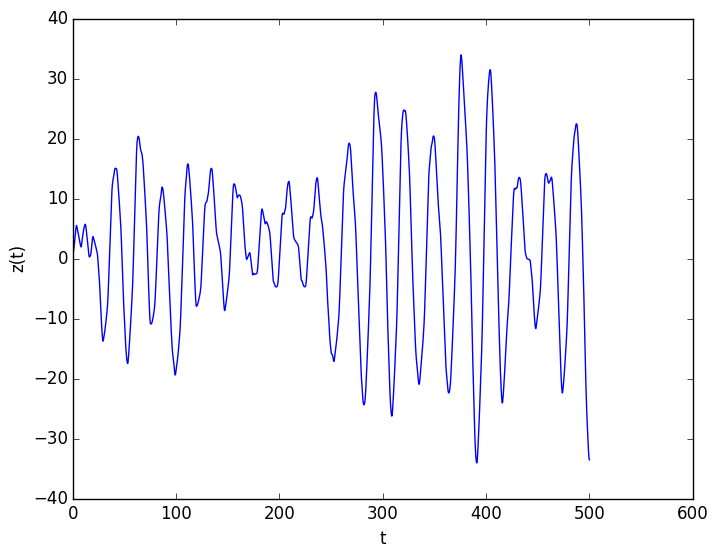

In [13]:
plot(hola[:,1],hola[:,2])
xlabel("t")
ylabel("z(t)")
legend();

Usamos Interact para checar los parámetros: 

In [14]:
using Interact

  likely near /home/aixa/.julia/v0.4/Interact/src/IJulia/setup.jl:153
  likely near /home/aixa/.julia/v0.4/Interact/src/IJulia/setup.jl:157


 in depwarn at deprecated.jl:73
 in call at deprecated.jl:50
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:304
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:304
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:304
 in require at ./loading.jl:243
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at /home/aixa/.julia/v0.4/IJulia/src/execute_request.jl:177
 in eventloop at /home/aixa/.julia/v0.4/IJulia/src/IJulia.jl:141
 in anonymous at task.jl:447
while loading /home/aixa/.julia/v0.4/Interact/src/IJulia/statedict.jl, in expression starting on line 1


Interact.Options{:ToggleButtons,Float64}([Reactive.Input{Float64}] 0.0,"ϕ",0.0,"0.0",Interact.OptionDict(Any["0.0","0.19634954084936207","0.39269908169872414","0.5890486225480862","0.7853981633974483","0.9817477042468103","1.1780972450961724","1.3744467859455345","1.5707963267948966","1.7671458676442586"  …  "4.516039439535327","4.71238898038469","4.908738521234052","5.105088062083414","5.301437602932776","5.497787143782138","5.6941366846315","5.890486225480862","6.086835766330224","6.283185307179586"],Dict{Any,Any}("6.086835766330224"=>6.086835766330224,"1.3744467859455345"=>1.3744467859455345,"0.9817477042468103"=>0.9817477042468103,"2.1598449493429825"=>2.1598449493429825,"4.71238898038469"=>4.71238898038469,"5.301437602932776"=>5.301437602932776,"1.9634954084936207"=>1.9634954084936207,"2.552544031041707"=>2.552544031041707,"1.5707963267948966"=>1.5707963267948966,"2.748893571891069"=>2.748893571891069,"5.105088062083414"=>5.105088062083414,"3.3379421944391554"=>3.3379421944391554,"1.7671458676442586"=>1.7671458676442586,"0.5890486225480862"=>0.5890486225480862,"3.9269908169872414"=>3.9269908169872414,"0.7853981633974483"=>0.7853981633974483,"3.141592653589793"=>3.141592653589793,"3.730641276137879"=>3.730641276137879,"2.945243112740431"=>2.945243112740431,"4.319689898685965"=>4.319689898685965,"0.39269908169872414"=>0.39269908169872414,"5.6941366846315"=>5.6941366846315,"6.283185307179586"=>6.283185307179586,"0.19634954084936207"=>0.19634954084936207,"1.1780972450961724"=>1.1780972450961724,"4.908738521234052"=>4.908738521234052,"0.0"=>0.0,"2.356194490192345"=>2.356194490192345,"4.516039439535327"=>4.516039439535327,"5.890486225480862"=>5.890486225480862,"3.5342917352885173"=>3.5342917352885173,"4.123340357836604"=>4.123340357836604,"5.497787143782138"=>5.497787143782138)),Any[],Any[])

Interact.Options{:ToggleButtons,Float64}([Reactive.Input{Float64}] 0.0,"x_in0",0.0,"0.0",Interact.OptionDict(Any["0.0","0.19634954084936207","0.39269908169872414","0.5890486225480862","0.7853981633974483","0.9817477042468103","1.1780972450961724","1.3744467859455345","1.5707963267948966","1.7671458676442586"  …  "4.516039439535327","4.71238898038469","4.908738521234052","5.105088062083414","5.301437602932776","5.497787143782138","5.6941366846315","5.890486225480862","6.086835766330224","6.283185307179586"],Dict{Any,Any}("6.086835766330224"=>6.086835766330224,"1.3744467859455345"=>1.3744467859455345,"0.9817477042468103"=>0.9817477042468103,"2.1598449493429825"=>2.1598449493429825,"4.71238898038469"=>4.71238898038469,"5.301437602932776"=>5.301437602932776,"1.9634954084936207"=>1.9634954084936207,"2.552544031041707"=>2.552544031041707,"1.5707963267948966"=>1.5707963267948966,"2.748893571891069"=>2.748893571891069,"5.105088062083414"=>5.105088062083414,"3.3379421944391554"=>3.3379421944391554,"1.7671458676442586"=>1.7671458676442586,"0.5890486225480862"=>0.5890486225480862,"3.9269908169872414"=>3.9269908169872414,"0.7853981633974483"=>0.7853981633974483,"3.141592653589793"=>3.141592653589793,"3.730641276137879"=>3.730641276137879,"2.945243112740431"=>2.945243112740431,"4.319689898685965"=>4.319689898685965,"0.39269908169872414"=>0.39269908169872414,"5.6941366846315"=>5.6941366846315,"6.283185307179586"=>6.283185307179586,"0.19634954084936207"=>0.19634954084936207,"1.1780972450961724"=>1.1780972450961724,"4.908738521234052"=>4.908738521234052,"0.0"=>0.0,"2.356194490192345"=>2.356194490192345,"4.516039439535327"=>4.516039439535327,"5.890486225480862"=>5.890486225480862,"3.5342917352885173"=>3.5342917352885173,"4.123340357836604"=>4.123340357836604,"5.497787143782138"=>5.497787143782138)),Any[],Any[])

Interact.Options{:ToggleButtons,Float64}([Reactive.Input{Float64}] 0.0,"x_ex0",0.0,"0.0",Interact.OptionDict(Any["0.0","0.19634954084936207","0.39269908169872414","0.5890486225480862","0.7853981633974483","0.9817477042468103","1.1780972450961724","1.3744467859455345","1.5707963267948966","1.7671458676442586"  …  "4.516039439535327","4.71238898038469","4.908738521234052","5.105088062083414","5.301437602932776","5.497787143782138","5.6941366846315","5.890486225480862","6.086835766330224","6.283185307179586"],Dict{Any,Any}("6.086835766330224"=>6.086835766330224,"1.3744467859455345"=>1.3744467859455345,"0.9817477042468103"=>0.9817477042468103,"2.1598449493429825"=>2.1598449493429825,"4.71238898038469"=>4.71238898038469,"5.301437602932776"=>5.301437602932776,"1.9634954084936207"=>1.9634954084936207,"2.552544031041707"=>2.552544031041707,"1.5707963267948966"=>1.5707963267948966,"2.748893571891069"=>2.748893571891069,"5.105088062083414"=>5.105088062083414,"3.3379421944391554"=>3.3379421944391554,"1.7671458676442586"=>1.7671458676442586,"0.5890486225480862"=>0.5890486225480862,"3.9269908169872414"=>3.9269908169872414,"0.7853981633974483"=>0.7853981633974483,"3.141592653589793"=>3.141592653589793,"3.730641276137879"=>3.730641276137879,"2.945243112740431"=>2.945243112740431,"4.319689898685965"=>4.319689898685965,"0.39269908169872414"=>0.39269908169872414,"5.6941366846315"=>5.6941366846315,"6.283185307179586"=>6.283185307179586,"0.19634954084936207"=>0.19634954084936207,"1.1780972450961724"=>1.1780972450961724,"4.908738521234052"=>4.908738521234052,"0.0"=>0.0,"2.356194490192345"=>2.356194490192345,"4.516039439535327"=>4.516039439535327,"5.890486225480862"=>5.890486225480862,"3.5342917352885173"=>3.5342917352885173,"4.123340357836604"=>4.123340357836604,"5.497787143782138"=>5.497787143782138)),Any[],Any[])

Interact.Options{:ToggleButtons,Float64}([Reactive.Input{Float64}] 0.0,"x_MR0",0.0,"0.0",Interact.OptionDict(Any["0.0","0.19634954084936207","0.39269908169872414","0.5890486225480862","0.7853981633974483","0.9817477042468103","1.1780972450961724","1.3744467859455345","1.5707963267948966","1.7671458676442586"  …  "4.516039439535327","4.71238898038469","4.908738521234052","5.105088062083414","5.301437602932776","5.497787143782138","5.6941366846315","5.890486225480862","6.086835766330224","6.283185307179586"],Dict{Any,Any}("6.086835766330224"=>6.086835766330224,"1.3744467859455345"=>1.3744467859455345,"0.9817477042468103"=>0.9817477042468103,"2.1598449493429825"=>2.1598449493429825,"4.71238898038469"=>4.71238898038469,"5.301437602932776"=>5.301437602932776,"1.9634954084936207"=>1.9634954084936207,"2.552544031041707"=>2.552544031041707,"1.5707963267948966"=>1.5707963267948966,"2.748893571891069"=>2.748893571891069,"5.105088062083414"=>5.105088062083414,"3.3379421944391554"=>3.3379421944391554,"1.7671458676442586"=>1.7671458676442586,"0.5890486225480862"=>0.5890486225480862,"3.9269908169872414"=>3.9269908169872414,"0.7853981633974483"=>0.7853981633974483,"3.141592653589793"=>3.141592653589793,"3.730641276137879"=>3.730641276137879,"2.945243112740431"=>2.945243112740431,"4.319689898685965"=>4.319689898685965,"0.39269908169872414"=>0.39269908169872414,"5.6941366846315"=>5.6941366846315,"6.283185307179586"=>6.283185307179586,"0.19634954084936207"=>0.19634954084936207,"1.1780972450961724"=>1.1780972450961724,"4.908738521234052"=>4.908738521234052,"0.0"=>0.0,"2.356194490192345"=>2.356194490192345,"4.516039439535327"=>4.516039439535327,"5.890486225480862"=>5.890486225480862,"3.5342917352885173"=>3.5342917352885173,"4.123340357836604"=>4.123340357836604,"5.497787143782138"=>5.497787143782138)),Any[],Any[])

Interact.Slider{Float64}([Reactive.Input{Float64}] 0.5,"r",0.5,0.1:0.1:1.0)

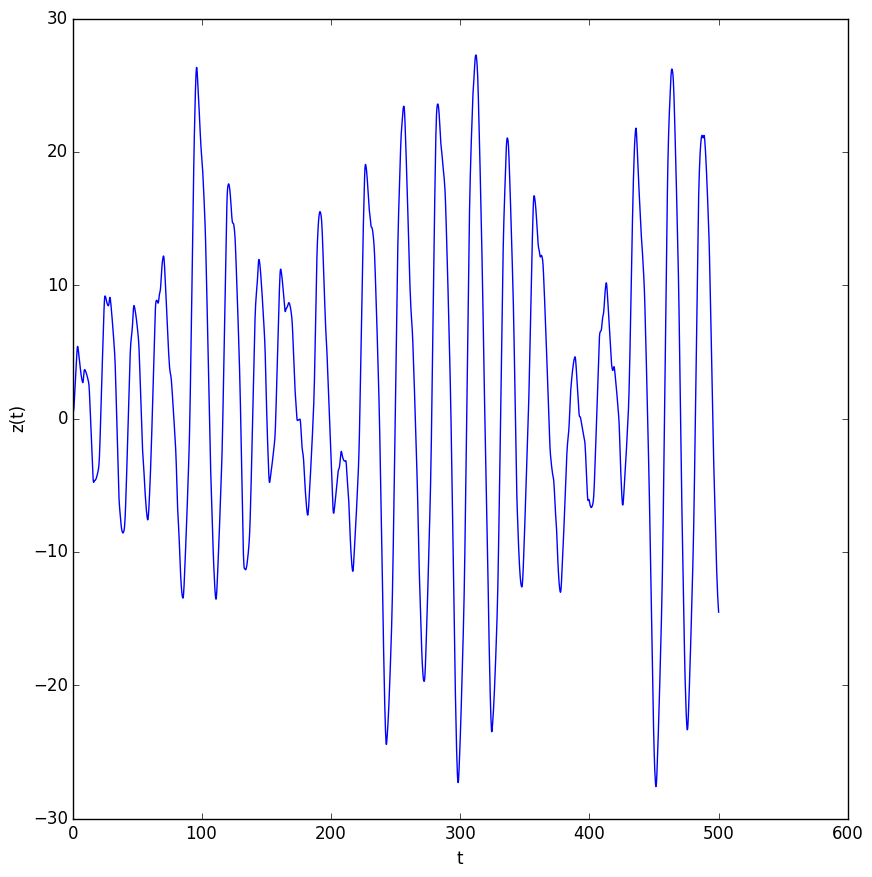

 in depwarn at deprecated.jl:73
 in oldstyle_vcat_warning at ./abstractarray.jl:29
 in vect at abstractarray.jl:32
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at /home/aixa/.julia/v0.4/IJulia/src/execute_request.jl:177
 in eventloop at /home/aixa/.julia/v0.4/IJulia/src/IJulia.jl:141
 in anonymous at task.jl:447
while loading In[15], in expression starting on line 1


In [15]:
intervalo=[0:π/16:2*π]
@manipulate for ϕ in intervalo, x_in0 in intervalo, x_ex0 in intervalo, x_MR0 in intervalo, r in .1:.1:1 
    withfig(figure(figsize=(10,10))) do
        
        dieg=z(500.0,Running,10.0^(-10),20,x_in0,x_ex0,x_MR0,r,ϕ)
        plot(dieg[:,1],dieg[:,2])
    end
end
xlabel("t")
ylabel("z(t)")
legend();